In [1]:
%run functions.ipynb

Ready: 2023-05-10 04:23:33


In [13]:
findspark.init()
from pyspark.sql import SparkSession
try:
    spark.stop()
except:
    pass
spark = SparkSession.builder\
        .master("local[*]")\
        .appName('PySpark')\
        .getOrCreate()
spark

In [ ]:
def repack_file(file_name):
    new_name = file_name.replace('\\', '\\\\').replace('.csv', '_repacked.csv')
    print(new_name)
    start_t = time.time()
    df_schema = StructType([StructField('user', StringType(), True), StructField('proj', StringType(), True), StructField('rubricName', StringType(), True), StructField('rubricID', StringType(), True), StructField('time', StringType(), True), StructField('date', StringType(), True), StructField('org', StringType(), True), StructField('branch', StringType(), True), StructField('prod', StringType(), True), StructField('tx', StringType(), True), StructField('fl', StringType(), True), StructField('devmod', StringType(), True), StructField('lat', StringType(), True), StructField('lon', StringType(), True)])
    df1 = spark.read.csv(file_name, header='true', schema=df_schema).selectExpr('rubricName','substr(time, 12, 8) as time','date','tx', 'hash(user) user').where('rubricName is not null')
    df1.coalesce(1).write.format("com.databricks.spark.csv").option("header", "true").mode('overwrite').csv(new_name)  
    end_t = time.time()
    print(end_t-start_t)

df = dd.read_csv(files_list[0][0])

df.head()

df.to_csv('df.csv', index=False)

repack_file('df.csv')

Пример форматирования строки:
'За %g года я купил %d %s.' % (3.5, 7, 'верблюдов’)
'{:020}'.format(1)

Пример получения текущего рабочего каталога:
import os
cwd = os.getcwd() # текущий каталог
os.listdir() #список файлов и каталогов текущего каталога
os.walk(dirname) # все вложенные файлы и папки
os.path.join(dir_name, file) # объединяем имя каталога и файла

Пример проверки файлов/директорий:
os.path.exists() #существует 
os.path.isdir() #каталог или нет 
os.path.isfile() #файл или нет

Пример копирования/перемещения файлов:
import shutil
original = r'original path where the file is currently stored\file name.file extension'
target = r'target path where the file will be copied\file name.file extension'
shutil.copy(original, target)
shutil.move(original, target)


import shutil

shutil.move()

os.remove() removes a file.

os.rmdir() removes an empty directory.

shutil.rmtree() deletes a directory and all its contents.

CPU times: total: 1min 39s
Wall time: 2min 34s


In [12]:
df_dates_all = pd.concat([pd.read_parquet(f'files/ten_city/df_dates_{col_r}').rename({col_r: 'date_r'}, axis=1)[['rubricName', 'date_r', 'cnt', 'city', 'year_r']] for col_r in ['hour_r', 'date_r', 'week_r', 'week_day_r']])
df_dates_all['city_rubric'] = df_dates_all['city'] + '. ' + df_dates_all['rubricName']
df_dates_all = df_dates_all[~df_dates_all.rubricName.apply(lambda x: (x is None or x.isnumeric()))]
df_cr = df_dates_all.groupby('city_rubric').sum('cnt').drop('year_r', axis=1)
dfx = pd.pivot_table(df_dates_all, values='cnt', aggfunc='sum', index=['date_r'], columns=['city_rubric'])

df_cr.to_parquet('files/ten_city/df_cr', index=False)
dfx.to_parquet('files/ten_city/dfx', index=False)

In [13]:
%%time 
t = dfx.corr()
t = t.rename_axis(None).rename_axis(None, axis=1)
t1 = t.stack().reset_index()
t1.columns = ['r1', 'r2', 'corr']
t1 = t1[t1.r1 != t1.r2]

CPU times: total: 1min 43s
Wall time: 2min 48s


In [16]:
t1.head()

,r1,r2,corr
1,Алматы. CD / DVD / BD,Алматы. Call-центры,0.965948
2,Алматы. CD / DVD / BD,Алматы. IP-телефония,0.953771
3,Алматы. CD / DVD / BD,Алматы. Indoor-реклама (реклама в помещениях),0.968397
4,Алматы. CD / DVD / BD,Алматы. PR / Связи с общественностью,0.960455
5,Алматы. CD / DVD / BD,Алматы. SPA-процедуры,0.993949


In [14]:
%%time
t1.to_parquet('files/ten_city/t1_corr', index=False)

KeyboardInterrupt: 

In [48]:
df_cr = df_cr[df_cr['cnt'] > 10000]

In [53]:
tt1 = t1.merge(df_cr, right_index=True, left_on='r1').rename({'cnt':'cnt_r1'},axis=1)
tt1 = tt1.merge(df_cr, right_index=True, left_on='r2').rename({'cnt':'cnt_r2'},axis=1)
tt1['cnt'] = tt1['cnt_r1'] + tt1['cnt_r2']
tt1['div'] = tt1['cnt_r1'] / tt1['cnt']
tt1 = tt1.sort_values(['cnt'], ascending=[False])

In [53]:
cc1 = c1.merge(df_cr, right_index=True, left_on='r1').rename({'cnt':'cnt_r1'},axis=1)
cc1 = cc1.merge(df_cr, right_index=True, left_on='r2').rename({'cnt':'cnt_r2'},axis=1)
cc1['cnt'] = cc1['cnt_r1'] + cc1['cnt_r2']
cc1['div'] = cc1['cnt_r1'] / cc1['cnt']
cc1 = cc1.sort_values(['cnt'], ascending=[False])

In [12]:
sns.heatmap(t, annot=True, cbar=False)
#plt.title('Бишкек.ТРЦ')
plt.show()


KeyboardInterrupt



Error in callback <function flush_figures at 0x000002685A76D4C0> (for post_execute):



KeyboardInterrupt



,cnt
city_rubric,
Алматы. CD / DVD / BD,221444
Алматы. Call-центры,45340
Алматы. IP-телефония,57100
Алматы. Indoor-реклама (реклама в помещениях),7076
Алматы. PR / Связи с общественностью,13816
Алматы. SPA-процедуры,1658416
Алматы. Абразивный инструмент,7628
Алматы. Аварийные службы,50328
Алматы. Авиабилеты,408080


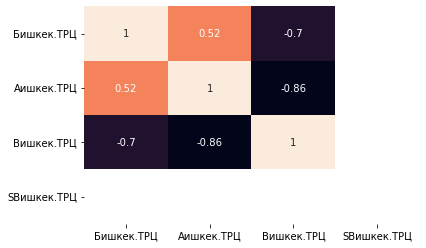

In [69]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'Бишкек.ТРЦ': [45, 37, 42, 35, 39],
        'Аишкек.ТРЦ': [38, 31, 26, 28, 33],
        'Вишкек.ТРЦ': [10, 15, 17, 21, 12],
        'SВишкек.ТРЦ': [1, 1, 1, 1, 1]
        }

df = pd.DataFrame(data)

corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True, cbar=False)
#plt.title('Бишкек.ТРЦ')
plt.show()

In [22]:
pd.read_excel('files/ten_city/df_dates_rubrics_city.xlsx', nrows=10)

,rubricName,city,diff,bucket,bucket_range
0,Жилищно-накопительные кооперативы,Москва,0.000280,0,"(-0.00072, 0.171]"
1,Тонизирующие салоны,ОАЭ,0.001655,0,"(-0.00072, 0.171]"
2,Услуги ведения беременности,Ташкент,0.001695,0,"(-0.00072, 0.171]"
3,Дистанционное зондирование земли (ДЗЗ) / Геоинформационные системы (ГИС),Ташкент,0.003695,0,"(-0.00072, 0.171]"
4,Диспансеры,ОАЭ,0.003886,0,"(-0.00072, 0.171]"
5,Рейтинговые агентства,Ташкент,0.005650,0,"(-0.00072, 0.171]"
6,Обучение имидж-консультантов,Владивосток,0.007355,0,"(-0.00072, 0.171]"
7,Обмен валюты,Астана,0.009189,0,"(-0.00072, 0.171]"
8,Рольставни,Ташкент,0.009723,0,"(-0.00072, 0.171]"
9,Продажа / монтаж декоративных аквасистем,Калининград,0.010435,0,"(-0.00072, 0.171]"
